In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [2]:
boston = load_boston()
print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

# Process Data

In [3]:
df_boston = pd.DataFrame(boston['data'], columns=boston['feature_names'])
df_boston['MEDV'] = boston['target'] # target median value of home in $1000's

# Feature engineering: Convert average number of rooms per dwelling to int
df_boston['num_rooms'] = df_boston['RM'].apply(lambda x: int(x)) 

print(f'Dataset size: {df_boston.shape}')
df_boston.head()

Dataset size: (506, 15)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,6
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,6
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,7


In [4]:
# Split dataframe into train and test
df_train, df_test = train_test_split(df_boston, test_size=0.2, random_state=42)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
print(f'Size of train set: {df_train.shape}')
print(f'Size of test set: {df_test.shape}')

Size of train set: (404, 16)
Size of test set: (102, 16)


In [5]:
# Distribution of train
df_train.describe()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,250.428218,3.584372,11.569307,10.985050,0.071782,0.556484,6.315891,68.556436,3.808195,9.356436,404.032178,18.318317,356.278342,12.457351,22.796535,5.804455
std,142.332893,8.869255,23.152481,6.894618,0.258447,0.117704,0.709452,27.994922,2.131226,8.589721,166.172655,2.228701,91.566533,7.110381,9.332147,0.790062
min,1.000000,0.009060,0.000000,0.740000,0.000000,0.385000,3.863000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,3.000000
25%,132.250000,0.081437,0.000000,5.130000,0.000000,0.452000,5.890500,45.550000,2.087875,4.000000,279.000000,16.800000,375.472500,6.772500,16.950000,5.000000
50%,249.500000,0.261390,0.000000,8.560000,0.000000,0.538000,6.210000,77.700000,3.175750,5.000000,330.000000,18.700000,391.305000,10.925000,21.600000,6.000000
75%,369.250000,2.983900,20.000000,18.100000,0.000000,0.631000,6.636750,93.650000,5.400800,12.000000,666.000000,20.200000,395.755000,16.372500,26.400000,6.000000
max,505.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,8.000000


In [6]:
# Distribution of test
df_test.describe()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,260.705882,3.630947,10.549020,11.737745,0.058824,0.547609,6.160833,68.648039,3.742949,10.313725,424.892157,18.999020,358.241275,13.428235,21.488235,5.666667
std,161.162337,7.459607,24.083242,6.722576,0.236456,0.108602,0.663825,28.890866,2.010749,9.161889,177.462472,1.800577,90.641872,7.244601,8.605804,0.722116
min,0.000000,0.006320,0.000000,0.460000,0.000000,0.392000,3.561000,6.200000,1.169100,1.000000,188.000000,13.000000,6.680000,2.880000,5.000000,3.000000
25%,90.750000,0.087368,0.000000,6.102500,0.000000,0.448250,5.870250,43.800000,2.263950,4.000000,281.750000,18.400000,375.020000,7.687500,17.125000,5.000000
50%,272.500000,0.209885,0.000000,10.590000,0.000000,0.532000,6.170500,74.700000,3.353400,5.000000,345.000000,19.200000,392.205000,12.335000,20.150000,6.000000
75%,410.250000,4.522473,0.000000,18.100000,0.000000,0.621500,6.479250,95.225000,4.764825,24.000000,666.000000,20.200000,396.900000,18.017500,24.075000,6.000000
max,501.000000,45.746100,95.000000,27.740000,1.000000,0.871000,8.034000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,36.980000,50.000000,8.000000


# Baseline Models

1. Use overall mean value of all houses in the train set
2. Use mean value based on number of rooms in the train set

In [7]:
print('Overall mean value: $%.2f' % (df_train['MEDV'].mean() * 1000))

Overall mean value: $22796.53


In [8]:
# Get mean value based on number of rooms (and make sure there are enough samples)
df_num_rooms = df_train.groupby('num_rooms').agg({'MEDV': ['mean', 'count']}).reset_index()
df_num_rooms.columns = [' '.join(col).strip() for col in df_num_rooms.columns.values]
df_num_rooms

,num_rooms,MEDV mean,MEDV count
0,3,23.100000,1
1,4,17.320000,10
2,5,17.654400,125
3,6,21.926066,211
4,7,36.793333,45
5,8,43.716667,12


Since there's only one sample for 3 bedroom dwellings, we'll fall back to the overall mean in this case.

In [9]:
# Store mean value by number of rooms in a dictionary
num_rooms_value_dict = {}
for _, row in tqdm(df_num_rooms.iterrows()):
    if row['num_rooms'] == 3: # fall back to overall mean
        num_rooms_value_dict[row['num_rooms']] = df_train['MEDV'].mean()
    else:
        num_rooms_value_dict[row['num_rooms']] = row['MEDV mean']

6it [00:00, 3000.93it/s]


In [10]:
# Augment test dataframe with baseline model results
df_test['overall_mean_val'] = df_train['MEDV'].mean()
df_test['rooms_mean_val'] = df_test.apply(lambda x: num_rooms_value_dict[x['num_rooms']], axis=1)

# Regression Model

In [11]:
print(f"Number of features: {len(boston['feature_names'])}")

Number of features: 13


In [13]:
X_train = df_train[boston['feature_names']]
X_test = df_test[boston['feature_names']]
y_train = df_train[['MEDV']].values

In [44]:
# Perform grid search to determine 'optimum' hyperparameters
model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(random_state=42)), 
                                 ('regression', GradientBoostingRegressor(loss='ls', 
                                                                          random_state=42))])
n_components = [2, 4, 8, 10, 13]
n_estimators = [10, 100, 500, 1000]
max_depths = [3, 10, 50, 100]

estimator  = GridSearchCV(model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                                        pca__n_components=n_components,
                                        regression__n_estimators=n_estimators,
                                        regression__max_depth=max_depths))
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   49.4s finished
C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('regression', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
      ...ors=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'pca__n_components': [2, 4, 8, 10, 13], 'regression__n_estimators': [10, 100, 500, 1000], 'regression__max_depth': [3, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [45]:
estimator.best_params_ 

{'pca__n_components': 13,
 'regression__max_depth': 3,
 'regression__n_estimators': 500}

In [46]:
best_model = estimator.best_estimator_

In [104]:
alpha = 0.95
best_model.set_params(**dict(pca__n_components=13,
                             regression__max_depth=3,
                             regression__n_estimators=500,
                             regression__loss='quantile', regression__alpha=alpha))
best_model.fit(X_train, y_train)
y_upper = best_model.predict(X_test)
best_model.set_params(**dict(pca__n_components=13,
                             regression__max_depth=3,
                             regression__n_estimators=500,
                             regression__loss='quantile', regression__alpha=1-alpha))
best_model.fit(X_train, y_train)
y_lower = best_model.predict(X_test)
best_model.set_params(**dict(pca__n_components=13,
                             regression__max_depth=3,
                             regression__n_estimators=500,
                             regression__loss='quantile', regression__alpha=0.5))
best_model.fit(X_train, y_train)
y_test = best_model.predict(X_test)

C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [116]:
df_test['model_val'] = y_test
df_test['model_spread'] = y_upper - y_lower # rough measure of IQR/SD
df_test['model_cov'] = df_test['model_spread'] / df_test['model_val'] # rough measure of coefficient of variation (cov)

# Evaluating Model Goodness

In [117]:
abs_error = lambda estimate, target: abs(estimate - target)
abs_pc_error = lambda estimate, target: abs(estimate - target) / target * 100
sq_error = lambda estimate, target: (estimate - target) ** 2
def compute_eval_metrics(df, estimate_col, target_col, model_name):
    # Absolute Error
    df[f'{model_name}_ae'] = df.apply(lambda row: abs_error(row[estimate_col], row[target_col]), axis=1)
    # Absolute % Error
    df[f'{model_name}_ape'] = df.apply(lambda row: abs_pc_error(row[estimate_col], row[target_col]), axis=1)
    # Squared Error
    df[f'{model_name}_se'] = df.apply(lambda row: sq_error(row[estimate_col], row[target_col]), axis=1)
    return df
df_test = compute_eval_metrics(df_test, 'overall_mean_val', 'MEDV', 'baseline1')
df_test = compute_eval_metrics(df_test, 'rooms_mean_val', 'MEDV', 'baseline2')
df_test = compute_eval_metrics(df_test, 'model_val', 'MEDV', 'reg_model')

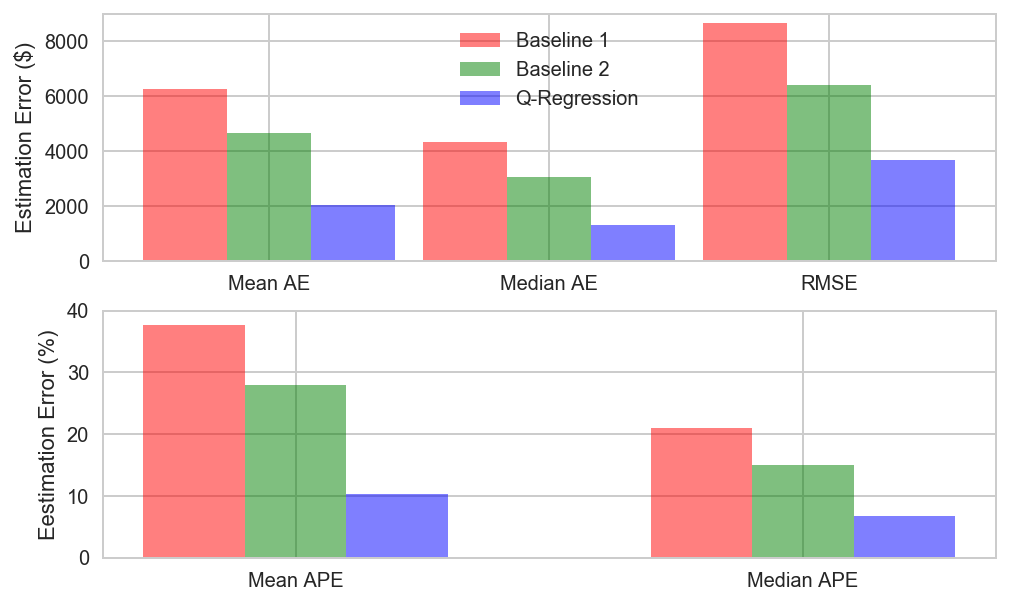

In [118]:
def plot_and_save_key_perf_metrics(df, filename):
    def compute_key_metrics_val(model_name):
        return [df[f'{model_name}_ae'].mean() * 1000,
                df[f'{model_name}_ae'].median() * 1000,
                math.sqrt(df[f'{model_name}_se'].mean()) * 1000]
    def compute_key_metrics_pc(model_name):
        return [df[f'{model_name}_ape'].mean(),
                df[f'{model_name}_ape'].median()]
    
    b1_metrics_val = compute_key_metrics_val('baseline1')
    b1_metrics_pc = compute_key_metrics_pc('baseline1')
    b2_metrics_val = compute_key_metrics_val('baseline2')
    b2_metrics_pc = compute_key_metrics_pc('baseline2')
    reg_metrics_val = compute_key_metrics_val('reg_model')
    reg_metrics_pc = compute_key_metrics_pc('reg_model')
    
    val_metrics = ['Mean AE', 'Median AE', 'RMSE']
    pc_metrics = ['Mean APE', 'Median APE']
    f, ax = plt.subplots(2, 1, figsize=(8, 5))
    val_index = np.arange(len(val_metrics))
    bar_width = 0.3
    opacity = 0.5
    ax[0].bar(val_index, b1_metrics_val, bar_width,
                alpha=opacity, color='r',
                label='Baseline 1')
    ax[0].bar(val_index + bar_width, b2_metrics_val, bar_width,
                    alpha=opacity, color='g',
                    label='Baseline 2')
    ax[0].bar(val_index + 2 * bar_width, reg_metrics_val, bar_width,
                    alpha=opacity, color='b',
                    label='Q-Regression')
    ax[0].set_xticks(val_index + bar_width)
    ax[0].set_xticklabels(val_metrics)
    ax[0].set_ylim([0, 9000])
    ax[0].set_ylabel('Estimation Error ($)')
    ax[0].legend()
    
    bar_width = 0.2
    pc_index = np.arange(len(pc_metrics))
    ax[1].bar(pc_index, b1_metrics_pc, bar_width,
                alpha=opacity, color='r',
                label='Baseline 1')
    ax[1].bar(pc_index + bar_width, b2_metrics_pc, bar_width,
                    alpha=opacity, color='g',
                    label='Baseline 2')
    ax[1].bar(pc_index + 2 * bar_width, reg_metrics_pc, bar_width,
                    alpha=opacity, color='b',
                    label='Q-Regression')
    ax[1].set_xticks(pc_index + bar_width)
    ax[1].set_xticklabels(pc_metrics)
    ax[1].set_ylim([0, 40])
    ax[1].set_ylabel('Eestimation Error (%)')
    f.savefig(filename, dpi=200, bbox_inches='tight')
plot_and_save_key_perf_metrics(df_test, 'images/reg_key_perf_metrics.png')

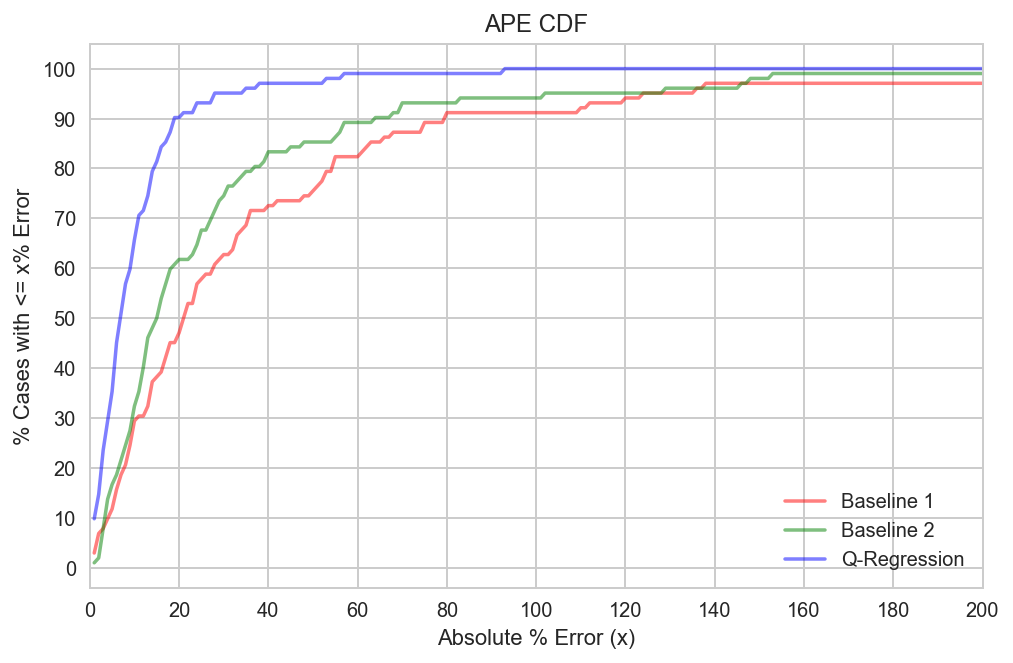

In [119]:
def plot_and_save_ape_cdf(df, filename, min_bin=0, max_bin=301, width=1):
    def compute_pdf_cdf(metric_col):
        hist, bins = np.histogram(df[metric_col], bins=np.arange(min_bin, max_bin, width))
        hist = hist / len(df) * 100 # normalise
        cumsum = np.cumsum(hist)
        return hist, cumsum, bins

    hist_b1, cumsum_b1, bins_b1 = compute_pdf_cdf('baseline1_ape')
    hist_b2, cumsum_b2, bins_b2 = compute_pdf_cdf('baseline2_ape')
    hist_reg, cumsum_reg, bins_reg = compute_pdf_cdf('reg_model_ape')
    f, ax = plt.subplots(figsize=(8, 5))
    opacity = 0.5
    ax.plot(bins_b1[1:], cumsum_b1, 'r-', alpha=opacity, label='Baseline 1')
    ax.plot(bins_b2[1:], cumsum_b2, 'g-', alpha=opacity, label='Baseline 2')
    ax.plot(bins_reg[1:], cumsum_reg, 'b-', alpha=opacity, label='Q-Regression')
    ax.set_xticks(np.arange(min_bin, max_bin, 20))
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xlim([0, 200])
    ax.legend()
    ax.set_xlabel('Absolute % Error (x)')
    ax.set_ylabel('% Cases with <= x% Error')
    ax.set_title('APE CDF')
    f.savefig(filename, dpi=200, bbox_inches='tight');
plot_and_save_ape_cdf(df_test, 'images/ape_cdf.png')

All = 100%
	Min APE = 0.10%
	Mean APE = 10.32%
	Median APE = 6.67%
	Max APE = 92.05%

50% Automated
	Min APE = 0.10%
	Mean APE = 5.92%
	Median APE = 5.15%
	Max APE = 17.06%


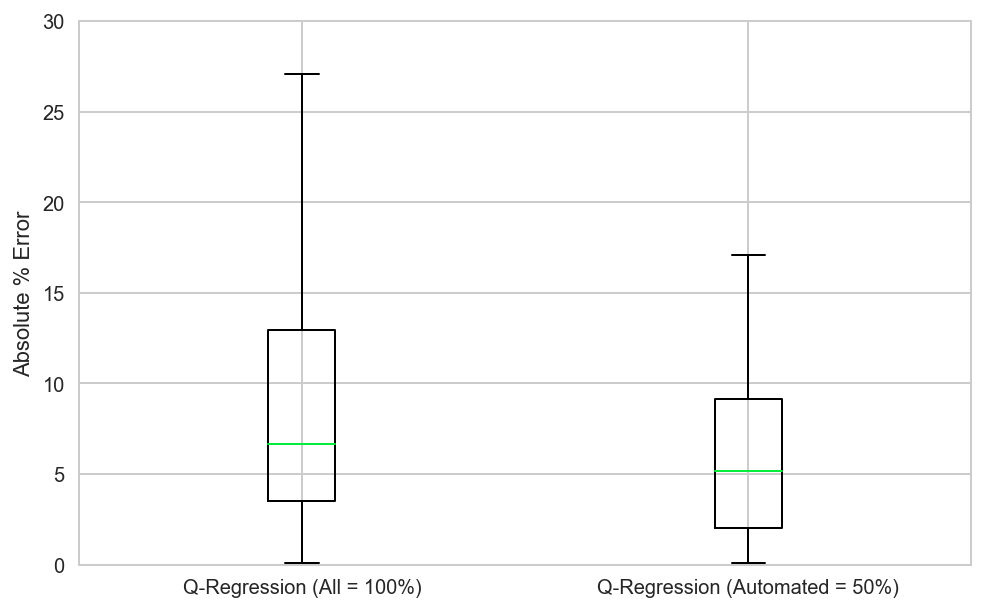

In [156]:
cov_threshold = 0.625
df_auto = df_test[df_test['model_cov'] <= cov_threshold].reset_index(drop=True)
print('All = 100%')
print('\tMin APE = %.2f%%' % (df_test['reg_model_ape'].min()))
print('\tMean APE = %.2f%%' % (df_test['reg_model_ape'].mean()))
print('\tMedian APE = %.2f%%' % (df_test['reg_model_ape'].median()))
print('\tMax APE = %.2f%%' % (df_test['reg_model_ape'].max()))
print('\n%d%% Automated' % (len(df_auto) / len(df_test) * 100))
print('\tMin APE = %.2f%%' % (df_auto['reg_model_ape'].min()))
print('\tMean APE = %.2f%%' % (df_auto['reg_model_ape'].mean()))
print('\tMedian APE = %.2f%%' % (df_auto['reg_model_ape'].median()))
print('\tMax APE = %.2f%%' % (df_auto['reg_model_ape'].max()))
f, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([df_test['reg_model_ape'], df_auto['reg_model_ape']])
ax.set_ylim([0, 30])
ax.set_xticklabels(['Q-Regression (All = 100%)', 'Q-Regression (Automated = %d%%)' % (len(df_auto) / len(df_test) * 100)])
ax.set_ylabel('Absolute % Error')
f.savefig('images/reg_automation.png', dpi=200, bbox_inches='tight');